In [1]:
from netCDF4 import Dataset, date2num, num2date
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mplticker
import matplotlib.colors as colors
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.dates as mdates
import string
import datetime as dt
import cftime as cf

from scipy import stats

%matplotlib inline

In [2]:
ellinkm = 100
fldLoc = '/scratch/srai6/EddyKillingPaper3/CESM/all7yrs/'
ds1 = Dataset(fldLoc + 'tavg_EPPA_100km.nc')
ds2 = Dataset(fldLoc + 'tavgNLmodelEP_0100km.nc')

slopeDS = Dataset(fldLoc + 'slopeAndCorr2D_0100km.nc')
slope = np.array(slopeDS.variables['slope'])
corr_coeff2d_fromFile = np.array(slopeDS.variables['corr_coeff'])

gridDS= Dataset('/scratch/srai6/EddyKillingPaper3/CESM/newGlobalGrid_tripolePOP_0.1deg.nc')
KMT = np.array(gridDS.variables['KMT'])
UAREA = np.array(gridDS.variables['UAREA'])
landMask = KMT < 30

In [3]:
corr_coeff2d_fromFile.shape
corr_coeff2d_fromFile[landMask] = float('nan')

In [4]:
NLMtot = np.array(ds2.variables['NLmodel_EPCg'][0,:,:])
NLM2tot = np.array(ds2.variables['NLmodel2_EPCg'][0,:,:])
EPPA = np.array(ds1.variables['EddyPowerPerArea'][0,:,:])
landMask = landMask + np.isnan(NLM2tot)
NLMtot[landMask] = float('nan')
EPPA[landMask] = float('nan')

In [5]:
print(np.nansum(UAREA * EPPA)*1e-16)
print(np.nansum(UAREA * NLMtot)*1e-16)
print(np.nansum(UAREA * NLM2tot)*1e-16)
ratio = np.nansum(UAREA * EPPA)/np.nansum(UAREA * (NLMtot+ NLM2tot))
print(ratio)
ratio = 2.729

-56.51999321688637
-16.521232304137097
-3.7437226210846464
2.7986988366973966


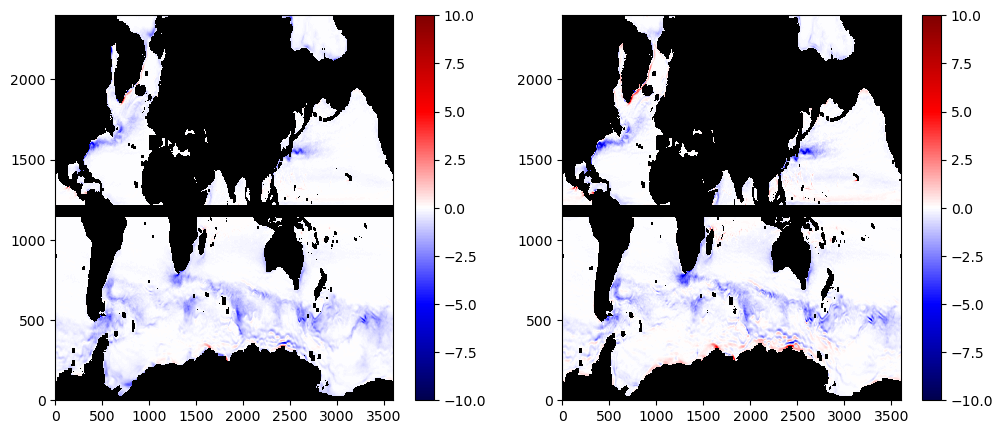

In [6]:
cmap = plt.get_cmap('seismic').copy()
cmap.set_bad('k')
v = 10

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
ax = axes[0]
pltArr = EPPA
m = ax.pcolormesh(pltArr, vmin=-v, vmax=v, cmap=cmap)
plt.colorbar(m, ax=ax)

ax = axes[1]
pltArr = ratio*(NLMtot + NLM2tot)
m = ax.pcolormesh(pltArr, vmin=-v, vmax=v, cmap=cmap)
plt.colorbar(m, ax=ax)

In [7]:
dsEPPA_inst = Dataset(fldLoc + '010.nc_0100_Filtered.nc')
dsNLM_inst = Dataset(fldLoc + '010_NLmodelEP_0100km.nc')

iNLMtot = np.array(dsNLM_inst.variables['NLmodel_EPCg'][0,:,:])
iNLM2tot = np.array(dsNLM_inst.variables['NLmodel2_EPCg'][0,:,:])
iEPPA = np.array(dsEPPA_inst.variables['EddyPowerPerArea'][0,:,:])

mask = landMask + np.isnan(iNLMtot)
iNLMtot[mask] = float('nan')
iNLM2tot[mask] = float('nan')
iEPPA[mask] = float('nan')

In [8]:
origFile = 'allEllallRegionsEP.nc'
modelFile = 'allEllallRegionsEP_ModelRotAndStrComp.nc'
orig_ds = Dataset(fldLoc + origFile)
modl_ds = Dataset(fldLoc + modelFile)

regions = np.array(modl_ds.variables['region'])
nregions = len(regions)
ell = np.array(modl_ds.variables['ell'])
nell = len(ell)

EPPA_TS = np.array(orig_ds.variables['EPPA'])
NLM_totPA_TS = np.array(modl_ds.variables['NLM_tot_PerArea'])
NLM2_totPA_TS = np.array(modl_ds.variables['NLM2Order_tot_PerArea'])
NLM_rotPA_TS = np.array(modl_ds.variables['NLM_rot_PerArea'])
NLM_strPA_TS = np.array(modl_ds.variables['NLM_str_PerArea'])

In [9]:
EPPA_TS.shape

(1, 9, 365)

In [10]:
dateUnits = 'days since 0050-01-01 00:00:00'

ndays = 365

cfdates = num2date(7 * (np.arange(ndays) + 1) - 4, dateUnits, calendar='noleap')
strdates = ['{0:02d}/{1:02d}/{2:04d}'.format(d.month, d.day, d.year) for d in cfdates]
dates = [dt.datetime.strptime(d, '%m/%d/%Y').date() for d in strdates]

years = mdates.YearLocator()   # every year
#months = mdates.MonthLocator(interval =4)  # every 4 month
months = mdates.MonthLocator(bymonth = (4,7,10))
#months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')
months_fmt = mdates.DateFormatter('%b')

date_fmt = mdates.DateFormatter('%b %Y')


PlotTitle = {'Gulf': 'Gulf Stream',
             'Kuroshio': 'Kuroshio Extension',
             'BrazilACC': 'Brazil Malvinas',
             'Agulhas': 'Agulhas',
             'ACC': 'ACC',
             'Equator': 'Equator',
             'SouthernOcean': 'Southern Ocean',
             'Global': 'Global'}





def plot_Trend(ellList, all_EP, all_NLM_tot, plt_labels, regions, regionName, ax, showXticks=True):
    #print('all_EP shape', np.shape(all_EP))
    #print('all_NLM_tot shape', np.shape(all_NLM_tot))
    
    regIdx = np.where(regions == regionName)[0][0]
    
    #print('region index', regIdx)
    
    EP = (all_EP[:,regIdx,:]).copy()
    NLM_tot = (all_NLM_tot[:,regIdx,:]).copy()
    #print('NLM_tot', np.shape(NLM_tot))
    
    avg_EP = np.mean(EP, axis = 1)
    avg_NLM_tot = np.mean(NLM_tot, axis = 1)
    
    print(np.shape(avg_NLM_tot))
    #ellIdx = np.argmin(avg_NLM_tot)
    ellIdx = np.where(ellList == 100)[0][0]
    #ellIdx = np.argmax(corr_EPPA_NLMtot[:,regIdx])
    
    #print('ell index', ellIdx)
    
    ell = ellList[ellIdx]
    
    EP = all_EP[ellIdx, regIdx,:].copy()
    NLM_tot = all_NLM_tot[ellIdx, regIdx,:].copy()
    
    ndays = len(EP)
    
    plt_runAvg_EP = np.ones((ndays), dtype =float) * float('nan')
    plt_runAvg_NLM = np.ones((ndays), dtype =float) * float('nan')
    
    ksize = 13
    half_ksize = ksize//2
    kernel = np.ones((ksize,), dtype=float)/ksize

    runAvg_EP = np.convolve(EP, kernel, mode='valid')
    runAvg_NLM = np.convolve(NLM_tot, kernel, mode='valid')
    
    lastindx = half_ksize+len(runAvg_EP)
                         
    plt_runAvg_EP[half_ksize:lastindx] = runAvg_EP
    plt_runAvg_NLM[half_ksize:lastindx] = runAvg_NLM
    
    coeffs= np.corrcoef(runAvg_EP, runAvg_NLM)[0, 1]
        
    slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress( runAvg_EP, runAvg_NLM )
    stdev_EP = np.std(runAvg_EP)
    stdev_NLM = np.std(runAvg_NLM)
    
    prob = 0.95
    Npoints = ndays - 2*half_ksize
    t_star = stats.t.cdf( 1 - (1-prob)/2, Npoints - 1 )
    
    std_err1 *=t_star *stdev_EP/stdev_NLM 
    #std_err2 *=t_star *stdev_NLM/stdev_NLM

    txt1 = r'r={0:>5.2f}$\pm${1:>4.2f}'.format(
            coeffs, 
            #slope1, 
            std_err1)
    
    txt3= r'{0:s}, $\ell$ = {1:d} km '.format(PlotTitle[regionName], ell)
    #txt3 = '{1:>{0}}'.format(len(region), txt3_dummy)
    txt = txt3 + '\n' + txt1 #+ '\n' + txt3 + txt2
        
    ax.plot(dates, EP, color='steelblue', alpha=0.4,rasterized = True)
    ax.plot(dates, NLM_tot, color='tomato', alpha=0.4,rasterized = True)
    

    ax.plot(dates, plt_runAvg_EP, color='steelblue', linewidth=2,rasterized = True, label=plt_labels[0])
    ax.plot(dates, plt_runAvg_NLM, color='tomato', linewidth=2,rasterized = True, label=plt_labels[1])

    #ax.axhline(linewidth=0.5, color='k',rasterized = True)#plot(dates, zero_line, linestyle=':', color='black')

    maxy = max(np.nanmax(plt_runAvg_NLM), np.nanmax(plt_runAvg_EP))
    miny = min(np.nanmin(plt_runAvg_NLM), np.nanmin(plt_runAvg_EP))
    
    diffy = maxy-miny

    ax.set_ylim([miny - 0.08 * diffy, (maxy + 0.40 * diffy)])

    ax.grid(visible=True, which='major', axis='both', linewidth=0.5, alpha = 0.5)
    ax.grid(visible=True, which='minor', axis='x', linewidth=0.1, alpha=0.2)
    
    
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(date_fmt)
    
    plt.setp(ax.yaxis.get_majorticklabels(), size=15)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=60, size=15)
    
    if showXticks==False:
        plt.setp(ax.get_xticklabels(), visible=False)
    
    
    ax.text(0.12, 0.70, txt, horizontalalignment='left', fontweight = 'light', 
                    verticalalignment='bottom', transform=ax.transAxes, fontsize=17)


def showCommonColorbar(pmesh, cax, lim, cbUnits, 
                       greaterThan = True, lessThan = True,
                       aspect = 30, fraction = 1, pad = 0.00,
                       anchor = (0,0)):
    
    exp = int(np.log10(lim))
    if exp < 0: exp-=1    
    dlim = 2*lim/8
    tickList = list(np.arange(-lim, lim+dlim, dlim))

    if greaterThan and lessThan:
        extd = 'both'
    elif greaterThan and ~lessThan:
        extd = 'max'
    elif ~greaterThan and lessThan:
        extd = 'min'
    else:
        extd = 'neither'
    cb = fig.colorbar(pmesh, cax = cax,
                      #ax=axList.ravel().tolist(), 
                      ticks=tickList, extend = extd)#,
                      #aspect = aspect, fraction = fraction, pad = pad,
                      #anchor = anchor)
    #cb = plt.colorbar(pmesh, ax=ax, ticks=tickList)

    strTickList = ['{0:04.2f}'.format(x) for x in tickList]

    if greaterThan:
        strTickList[0] = '$<$' + strTickList[0]
    if lessThan:
        strTickList[-1] = '$>$' + strTickList[-1]

    cb.ax.set_yticklabels(strTickList)

    #cbTitle = r'({0})$\times 10^{1}$'.format(cbUnits, '{'+str(exp)+'}' )

    cbTitle = r'{0}'.format(cbUnits)

    cb.ax.set_title(cbTitle, size=15, pad=20)
    cb.ax.tick_params(labelsize=15)

0.8795811222381725
(1,)
(1,)


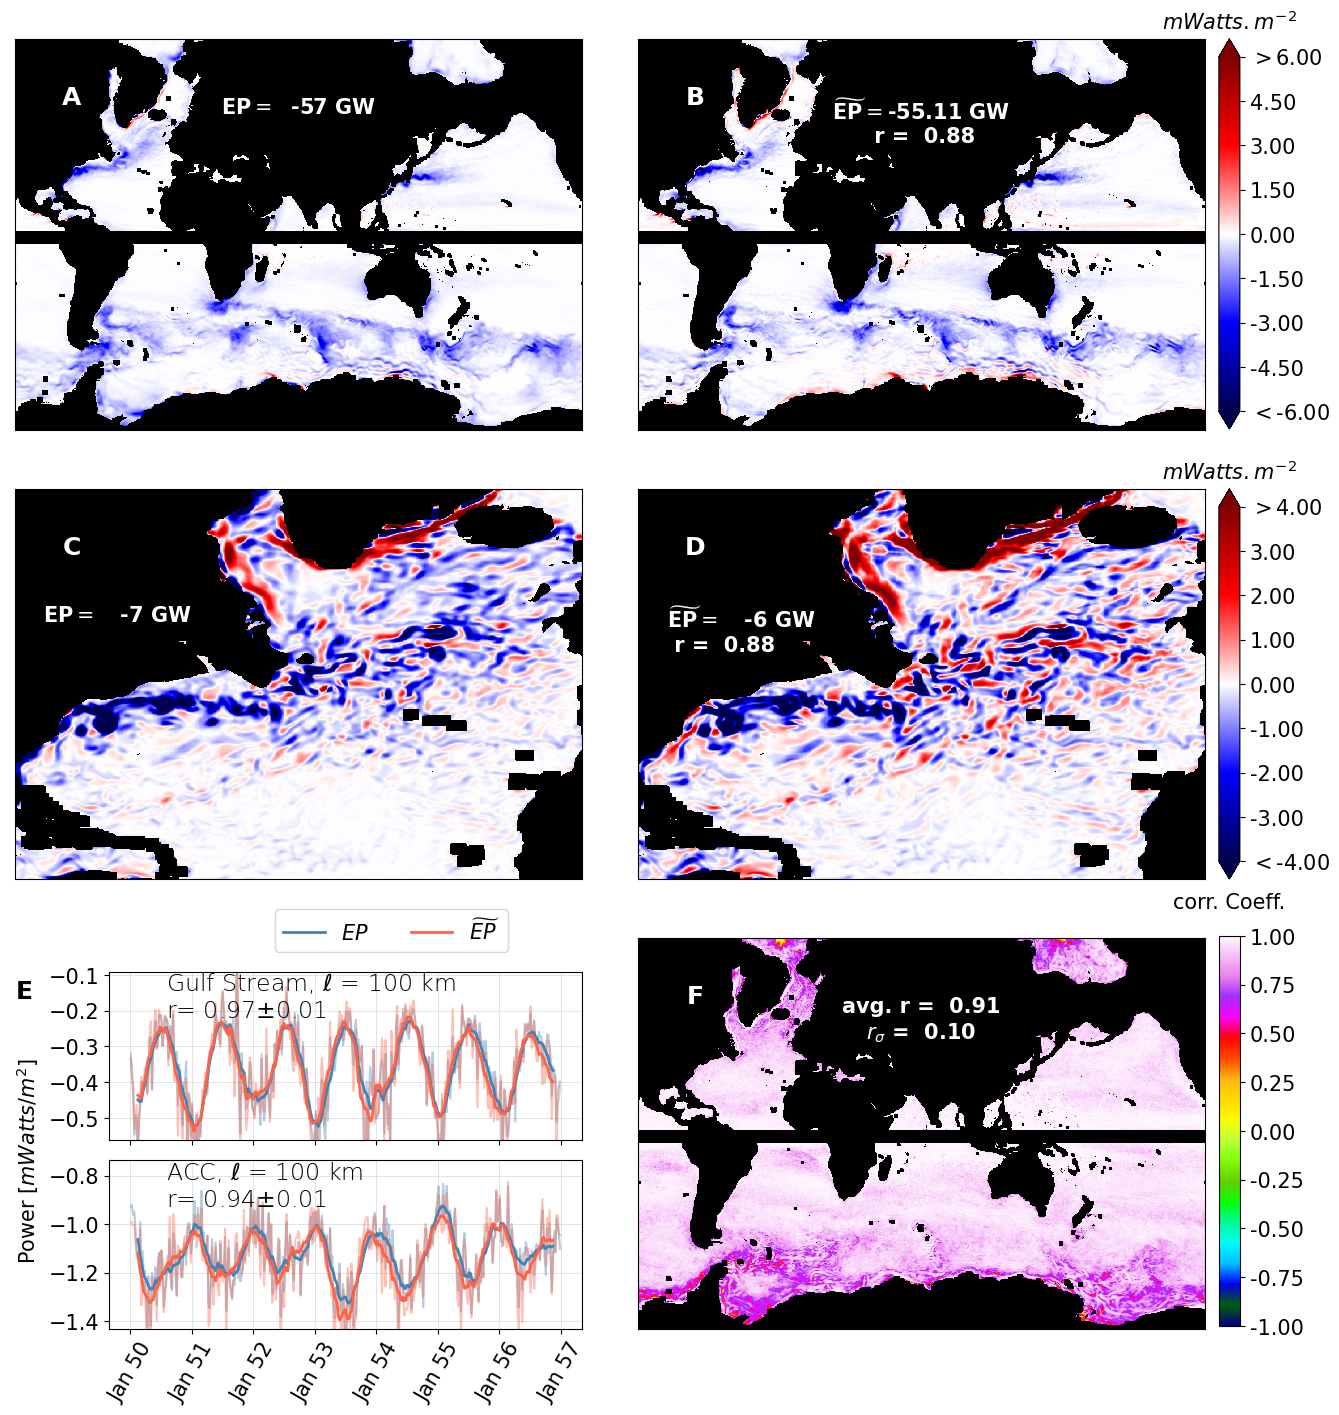

In [11]:
ratio = np.nansum(UAREA * EPPA)/np.nansum(UAREA * (NLMtot + NLM2tot))
ratio = 2.729 #slope #2.743

model = (NLMtot + NLM2tot) * ratio #slope
EPPA[mask] = float('nan')
model[mask] = float('nan')

x = EPPA.flatten()
y = model.flatten()
msk = np.isnan(x) + np.isnan(y)
corr_coeff = np.corrcoef(x[~msk], y[~msk])[0, 1]
print(corr_coeff)


cmap = plt.get_cmap('seismic').copy()
cmap.set_bad('k')

d = 6
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,15))


xpos = 0.5
ypos = 0.85
fsize = 15
cbTitle = r'$mWatts/m^2$'
ax = axes[0,0]
m = ax.pcolormesh(EPPA, vmin=-d, vmax=d, cmap=cmap, rasterized=True)
txt = r'$\mathbf{EP} = $' + '{0:5.0f} GW'.format(np.nansum(EPPA*UAREA*1e-7/1e9))
ax.text(xpos, ypos, txt, horizontalalignment='center', fontweight = 'heavy', color ='white' ,
                    verticalalignment='top', transform=ax.transAxes, fontsize=fsize)
# cb = plt.colorbar(m, ax=ax, extend='both')
# cb.ax.tick_params(labelsize=12)
# cb.ax.set_title(cbTitle, size=12, pad = 20)

xpos, ypos = 0.1, 0.85
ax.text(xpos, ypos, 'A', horizontalalignment='center',
         verticalalignment='center', transform=ax.transAxes, 
        fontsize = 18, weight='heavy', color='white')

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = axes[0,1]
m = ax.pcolormesh(model, vmin=-d, vmax=d, cmap=cmap, rasterized=True)
txt1 = r'$\mathbf{\widetilde{EP}} = $' + '{0:5.2f} GW'.format(np.nansum(model*UAREA*1e-7/1e9))
txt2 = '\n r = {0:5.2f}'.format(corr_coeff)
txt = txt1 + txt2

xpos = 0.5
ypos = 0.85
ax.text(xpos, ypos, txt, horizontalalignment='center', fontweight = 'heavy',  color ='white' ,
                    verticalalignment='top', transform=ax.transAxes, fontsize=fsize)
# cb = plt.colorbar(m, ax=ax, extend='both')
# cb.ax.tick_params(labelsize=12)
# cb.ax.set_title(cbTitle, size=12, pad = 20)
xpos, ypos = 0.1, 0.85
ax.text(xpos, ypos, 'B', horizontalalignment='center',
         verticalalignment='center', transform=ax.transAxes, 
        fontsize = 18, weight='heavy', color='white')

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

startx, starty, dx, dy = 0.91, 0.67, 0.015, 0.26
cax = fig.add_axes([startx, starty, dx, dy]) 
showCommonColorbar(m, cax, d, '$mWatts.m^{-2}$')
############################### INSTANTANEOUS PLOT #########################

y1 = 1300
y2 = 2000
x1 = 300
x2 = 1000
       
model = (iNLMtot + iNLM2tot)* ratio #+ iNLM2tot) * ratio

x = iEPPA[y1:y2,x1:x2].flatten()
y = model[y1:y2,x1:x2].flatten()
msk = np.isnan(x) + np.isnan(y)
r_local = np.corrcoef(x[~msk], y[~msk])[0, 1]

d = 4
xpos = 0.05
ypos = 0.70
#fsize = 12
cbTitle = r'$mWatts/m^2$'

ax =axes[1,0]
m = ax.pcolormesh(iEPPA[y1:y2,x1:x2], vmin=-d, vmax=d, cmap=cmap, rasterized=True)
txt = r'$\mathbf{EP} = $' + '{0:5.0f} GW'.format(np.nansum(EPPA[y1:y2,x1:x2]*UAREA[y1:y2,x1:x2]*1e-7/1e9))
ax.text(xpos, ypos, txt, horizontalalignment='left', fontweight = 'heavy',  color ='white' ,
                    verticalalignment='top', transform=ax.transAxes, fontsize=fsize)
# cb = plt.colorbar(m, ax=ax, extend='both')
# cb.ax.tick_params(labelsize=12)
# cb.ax.set_title(cbTitle, size=12, pad = 20)

xpos, ypos = 0.1, 0.85
ax.text(xpos, ypos, 'C', horizontalalignment='center',
         verticalalignment='center', transform=ax.transAxes, 
        fontsize = 18, weight='heavy', color='white')

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


ax =axes[1, 1]
m = ax.pcolormesh(model[y1:y2,x1:x2], vmin=-d, vmax=d, cmap=cmap, rasterized=True)
txt1 = r'$\mathbf{\widetilde{EP}} = $' + '{0:5.0f} GW'.format(np.nansum(model[y1:y2,x1:x2]*UAREA[y1:y2,x1:x2]*1e-7/1e9))
txt2 = '\n r = {0:5.2f}'.format(r_local)
txt = txt1 + txt2
xpos = 0.05
ypos = 0.70
ax.text(xpos, ypos, txt, horizontalalignment='left', fontweight = 'heavy',  color ='white' ,
                    verticalalignment='top', transform=ax.transAxes, fontsize=fsize)
# cb = plt.colorbar(m, ax=ax, extend='both')
# cb.ax.tick_params(labelsize=12)
# cb.ax.set_title(cbTitle, size=12, pad = 20)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

xpos, ypos = 0.1, 0.85
ax.text(xpos, ypos, 'D', horizontalalignment='center',
         verticalalignment='center', transform=ax.transAxes, 
        fontsize = 18, weight='heavy', color='white')

startx, starty, dx, dy = 0.91, 0.37, 0.015, 0.26
cax = fig.add_axes([startx, starty, dx, dy]) 
showCommonColorbar(m, cax, d, '$mWatts.m^{-2}$')


################################## TIMESEIRES and CORRELATION PLOT  ###########################
ratio = 2.729
plt_NLM_totPA_TS = NLM_totPA_TS * ratio 
plt_NLM2_totPA_TS = NLM2_totPA_TS * ratio 


axes[2,0].remove()
ax1 = fig.add_subplot(3, 2, 5)


plot_Trend(ell, EPPA_TS, plt_NLM_totPA_TS + plt_NLM2_totPA_TS, [r'$EP$', r'$\widetilde{EP}$'], regions, regions[5], ax1)
divider = make_axes_locatable(ax1)
axB = divider.append_axes("top", size="100%", pad=0.2)

plot_Trend(ell, EPPA_TS, plt_NLM_totPA_TS + plt_NLM2_totPA_TS, [r'$EP$', r'$\widetilde{EP}$'], regions, regions[0], axB,showXticks=False)

axC = divider.append_axes("top", size="8%", pad=0.2)
handles, labels = axB.get_legend_handles_labels()
axC.legend(handles, labels, ncol = 2, loc=(0.35,0.0), fontsize=15)

axC.axis('off')

ax0 = divider.append_axes("left", size="20%", pad=0.0)

ax0.text(0.0, 1, r'Power [$mWatts/m^2$]', rotation=90, fontsize=15, verticalalignment='center', 
         transform=ax0.transAxes, rasterized=True)

xpos, ypos = 0.1, 2
ax0.text(xpos, ypos, 'E', horizontalalignment='center',
         verticalalignment='center', transform=ax0.transAxes, 
        fontsize = 18, weight='heavy', color='k')

ax0.axis('off')

#axB.set_xticklabels([])

########################################

ax = axes[2,1]
corrcmap = plt.get_cmap('gist_ncar').copy()
corrcmap.set_bad('k')
rNLM_tot = corr_coeff2d_fromFile
avgCorr = np.nanmean(rNLM_tot)
stdCorr = np.nanstd(rNLM_tot)
text = 'avg. r = {0:4.2f}  '.format(avgCorr) + r'$\mathbf{r_{\sigma}} = $' +'{0:4.2f}'.format(stdCorr)

xpos = 0.5
ypos = 0.85
m = ax.pcolormesh(rNLM_tot, vmin=-1, vmax=1, cmap=corrcmap, rasterized=True)
txt1 = r'avg. r = {0:5.2f}'.format(avgCorr) 
txt2 = r'$r_\sigma$ = {0:5.2f} '.format(stdCorr)
txt = txt1 + '\n' + txt2
ax.text(xpos, ypos, txt, horizontalalignment='center', fontweight = 'heavy',  color ='white' ,
                    verticalalignment='top', transform=ax.transAxes, fontsize=fsize)
# cb = plt.colorbar(m, ax=ax, extend='both')
# cb.ax.tick_params(labelsize=12)
# cb.ax.set_title(cbTitle, size=12, pad = 20)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

xpos, ypos = 0.1, 0.85
ax.text(xpos, ypos, 'F', horizontalalignment='center',
         verticalalignment='center', transform=ax.transAxes, 
        fontsize = 18, weight='heavy', color='white')


startx, starty, dx, dy = 0.91, 0.072, 0.015, 0.26
cax = fig.add_axes([startx, starty, dx, dy])
showCommonColorbar(m, cax, 1, 'corr. Coeff.', greaterThan = False, lessThan = False)

plt.subplots_adjust(left=0.05, right=0.90, bottom=0.07, top = 0.93, wspace=0.1, hspace=0.15)

plt.savefig('CESM_ModelVsEP_{0:d}km.pdf'.format(ellinkm), dpi= 70)

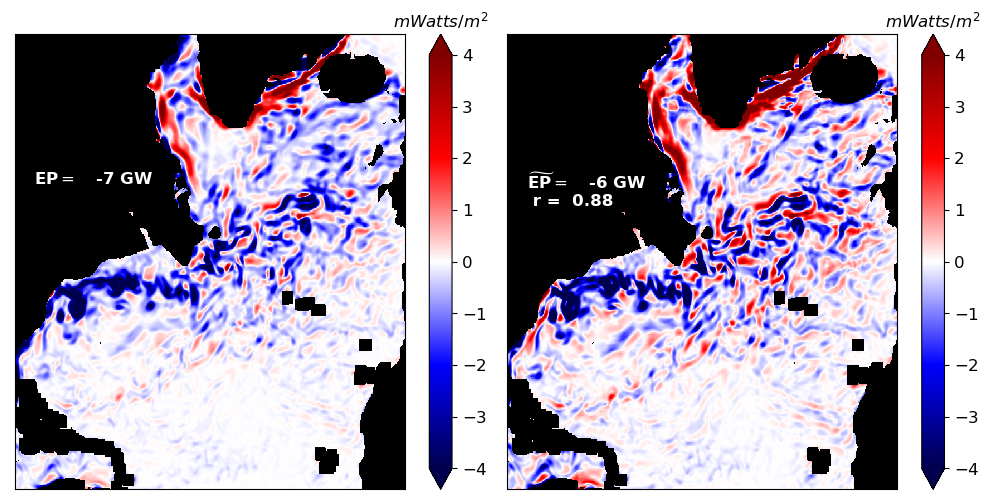

In [12]:
ratio = np.nansum(UAREA * EPPA)/np.nansum(UAREA * (NLMtot+ NLM2tot))
ratio = 2.743
y1 = 1300
y2 = 2000
x1 = 300
x2 = 1000
       
model = (iNLMtot + iNLM2tot)* ratio #+ iNLM2tot) * ratio

x = iEPPA[y1:y2,x1:x2].flatten()
y = model[y1:y2,x1:x2].flatten()
msk = np.isnan(x) + np.isnan(y)
r_local = np.corrcoef(x[~msk], y[~msk])[0, 1]

d = 4
xpos = 0.05
ypos = 0.70
fsize = 12
cbTitle = r'$mWatts/m^2$'

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

ax =axes[0]
m = ax.pcolormesh(iEPPA[y1:y2,x1:x2], vmin=-d, vmax=d, cmap=cmap, rasterized=True)
txt = r'$\mathbf{EP} = $' + '{0:5.0f} GW'.format(np.nansum(EPPA[y1:y2,x1:x2]*UAREA[y1:y2,x1:x2]*1e-7/1e9))
ax.text(xpos, ypos, txt, horizontalalignment='left', fontweight = 'heavy',  color ='white' ,
                    verticalalignment='top', transform=ax.transAxes, fontsize=fsize)
cb = plt.colorbar(m, ax=ax, extend='both')
cb.ax.tick_params(labelsize=12)
cb.ax.set_title(cbTitle, size=12, pad = 20)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


ax =axes[1]
m = ax.pcolormesh(model[y1:y2,x1:x2], vmin=-d, vmax=d, cmap=cmap, rasterized=True)
txt1 = r'$\mathbf{\widetilde{EP}} = $' + '{0:5.0f} GW'.format(np.nansum(model[y1:y2,x1:x2]*UAREA[y1:y2,x1:x2]*1e-7/1e9))
txt2 = '\n r = {0:5.2f}'.format(r_local)
txt = txt1 + txt2
ax.text(xpos, ypos, txt, horizontalalignment='left', fontweight = 'heavy',  color ='white' ,
                    verticalalignment='top', transform=ax.transAxes, fontsize=fsize)
cb = plt.colorbar(m, ax=ax, extend='both')
cb.ax.tick_params(labelsize=12)
cb.ax.set_title(cbTitle, size=12, pad = 20)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.subplots_adjust(left=0.02, bottom=0.02, right=1, top=0.93, wspace=0.01, hspace=0.01)

#plt.savefig('CESM_gulf_ModelVsEP_{0:d}.pdf'.format(ellinkm), dpi= 70)

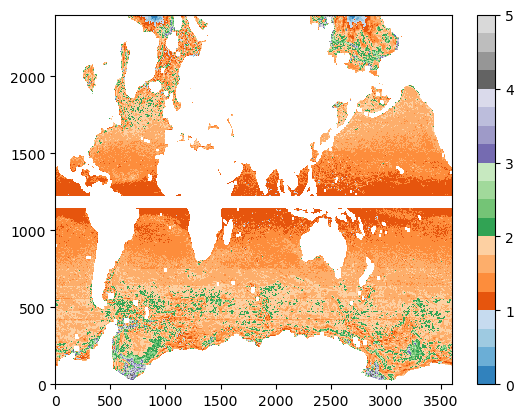

In [13]:
plt.pcolormesh(slope, cmap='tab20c', vmin=0, vmax=5)
plt.colorbar()

In [14]:
a = 33.02
b = 12.96
p = 57.12
q = 20.38

r = (a*b + p*q)/(b**2 + q**2)

In [15]:
r

2.7293475465707533